# Detect Cancerous Cells on Pathology Images

---  

*  December 2018
*  Cindy Wu




In [ ]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python
!pip install -U imbalanced-learn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 8 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 6s (15.9 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 110377 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16


## Download whole slides and generate patches for training

In [ ]:
slide_paths = ['tumor_091.tif','tumor_094.tif','tumor_096.tif','tumor_001.tif','tumor_084.tif', 'tumor_031.tif','tumor_078.tif']
tumor_mask_paths = ['tumor_091_mask.tif','tumor_094_mask.tif','tumor_096_mask.tif','tumor_001_mask.tif','tumor_084_mask.tif','tumor_031_mask.tif','tumor_078_mask.tif']


# Download the whole slide image from bucket
# 7 images and masks saved in bucket
for slide_path,tumor_mask_path in zip(slide_paths,tumor_mask_paths):
  slide_url = 'https://storage.googleapis.com/tumordata/%s'% slide_path
  mask_url = 'https://storage.googleapis.com/tumordata/%s'% tumor_mask_path
  
  # Download whole slides
  if not os.path.exists(slide_path):
    !curl -O $slide_url

  # Download the tumor mask
  if not os.path.exists(tumor_mask_path):
    !curl -O $mask_url
    

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  521M  100  521M    0     0   106M      0  0:00:04  0:00:04 --:--:--  116M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14.6M  100 14.6M    0     0  34.4M      0 --:--:-- --:--:-- --:--:-- 34.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1534M  100 1534M    0     0   116M      0  0:00:13  0:00:13 --:--:--  130M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51.7M  100 51.7M    0     0  66.7M      0 --:--:-- --:--:-- --:--:-- 66.7M
  % Total    % Received % Xferd  Average Speed   Tim

In [ ]:
# Function to read slides
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
# Find tissue pixels to improve efficiency
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return np.array(list(zip(indices[0], indices[1])))

def apply_mask(im, mask, color=(255,0,0)):
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked



In [ ]:
# Generate patches for slides and tumor masks
def gen_patches(slide,mask, h, w, s, level, ds):

    i = 0
    slide_patches = []
    mask_patches = []
    slide_h = slide.level_dimensions[level][1]
    slide_w = slide.level_dimensions[level][0]
    
    while i <= slide_h -h:
        j = 0
        while j <= slide_w -w:
          
          img_region = read_slide(slide, x=j*ds, y=i*ds, level=level, width=w, height=h)
          tissue_pixels = find_tissue_pixels(img_region)
          
          # Only keep patches with 5% or more tissues
          if len(tissue_pixels)/float(h*w) >= 0.05:
              tissue_patch = img_region 
              mask_patch = read_slide(mask, x=j*ds, y=i*ds, level=level, width=w, height=h)[:,:,0]

              
              slide_patches.append(np.array(tissue_patch).astype('float32')/255)
              mask_patches.append(np.array(mask_patch).astype('float32')/255)
           
          j = j + s

        i = i + s
        
    return slide_patches, mask_patches

In [ ]:
# Define 50 x 50 patch size and level 4 zoom
h = 50
w = 50
s = 50
level, ds = 4, 16

In [ ]:
# Generate patches
mask_patches=[]
slide_patches = []
for i in range(6):
  slide_patches_train, mask_patches_train = gen_patches(slide=open_slide(slide_paths[i]),mask = open_slide(tumor_mask_paths[i]), h=h, w = w, s=s, level = level, ds = ds)
  
  slide_patches = slide_patches + slide_patches_train
  mask_patches = mask_patches + mask_patches_train

slide_patches = np.array(slide_patches)

In [ ]:
# Generate labels for patches 
# Labeled as 1 as long as patch contains one cancerous cell
center_x = int((h-s)*0.5) # here h=s=w, but can use stride different than patch size and predict center
center_y = int((w-s)*0.5)
labels = np.array([1 if patch[center_x:center_x+s,center_y:center_y + s].sum() > 0 else 0 for patch in mask_patches])


In [ ]:
print ('Number of pacthes: {}'.format(len(slide_patches)))
print ('Number of cancerous patches: {}'.format(len(np.where(labels==1)[0])))

Number of pacthes: 28571
Number of cancerous patches: 956


Text(0.5,0.98,'Batch of Patches 32 x 50 x 50 x 3')

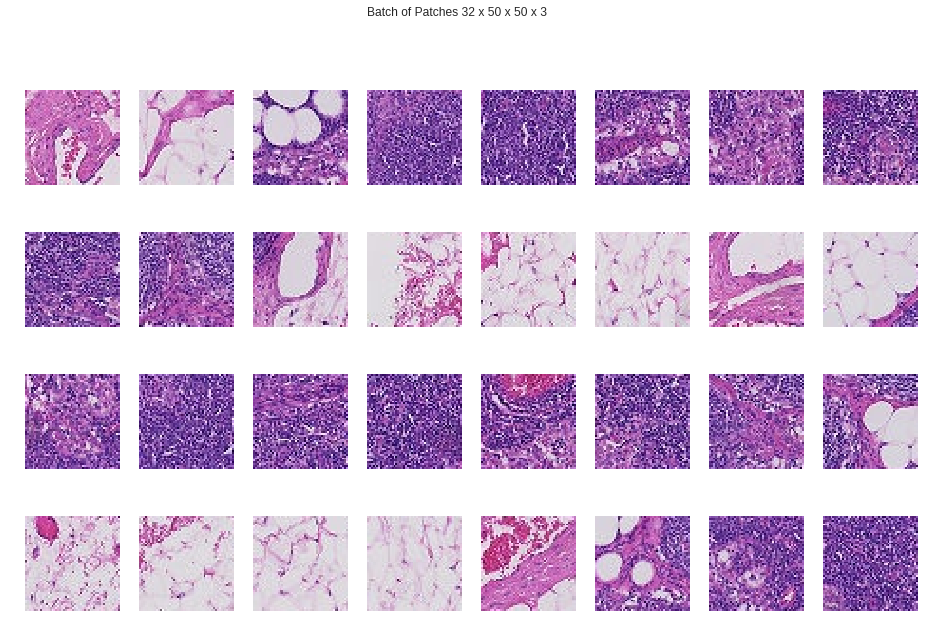

In [ ]:
# Sample patches
f, axes = plt.subplots(4, 8, figsize=(16, 10), dpi=100);
ax = axes.flatten()
for i in range(32):
    n = range(1000,10000,4)[i]
    _ = ax[i].imshow(slide_patches[n]);
    _ = ax[i].axis('off');
f.suptitle('Batch of Patches 32 x 50 x 50 x 3')
plt.show()

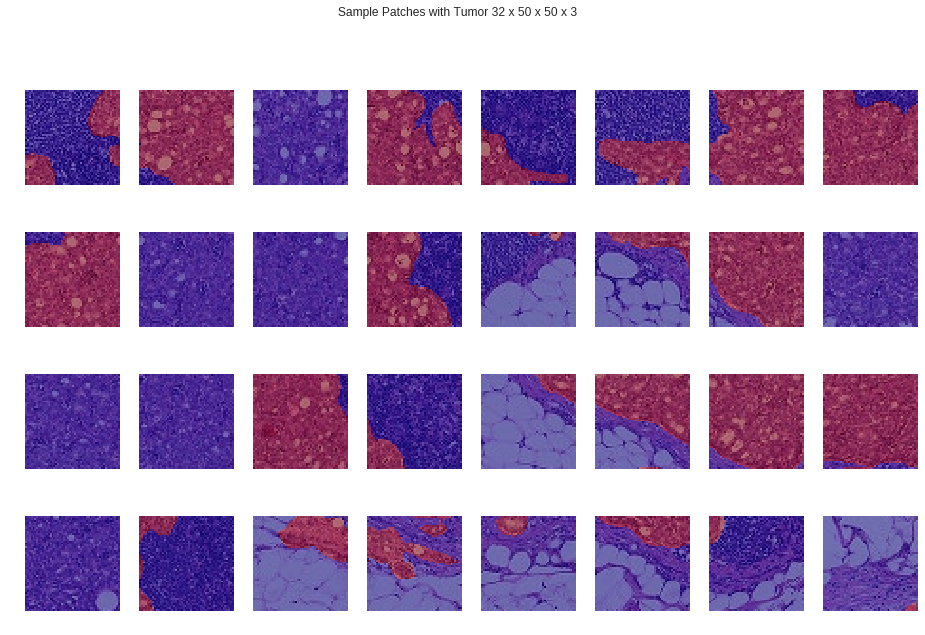

In [ ]:
# Sample patches with tumor
f, axes = plt.subplots(4, 8, figsize=(16, 10))
ax = axes.flatten()
for i in range(32):
    n = np.where(labels==1)[0][i+100]
    _ = ax[i].imshow(slide_patches[n]);
    _ = ax[i].imshow(mask_patches[n], cmap = 'jet', alpha = 0.5);                 
    _ = ax[i].axis('off');
f.suptitle('Sample Patches with Tumor 32 x 50 x 50 x 3')
plt.show()

# Train Model & generate heatmap

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score,precision_recall_curve,f1_score,roc_curve,auc,confusion_matrix


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(slide_patches, labels, stratify=labels,test_size=0.2, random_state=42)

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)

In [ ]:
print('Class weights: {}'.format(class_weights))

Class weights: [ 0.51731474 14.93856209]


In [ ]:
print('Training data shape: {}'.format(X_train.shape))
print('Test data shape: {}'.format(X_test.shape))

Training data shape: (22856, 50, 50, 3)
Test data shape: (5715, 50, 50, 3)


In [ ]:
# Load base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(h,w, 3))

In [ ]:
# Add additional dense layer and output layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# This is the model to train
model =  tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# Unfreeze one convolutional layer in VGG16
base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'block5_conv2':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        

In [ ]:
# Compile model for training
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True,
    width_shift_range=0.01,
      height_shift_range=0.01)

datagen.fit(X_train)


In [ ]:
epochs = 20
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=64), 
                              steps_per_epoch=len(X_train)//64, epochs=epochs, class_weight = class_weights)

Epoch 1/20
357/357 [==============================] - 30s 84ms/step - loss: 0.0652 - acc: 0.9778
Epoch 2/20
357/357 [==============================] - 30s 83ms/step - loss: 0.0623 - acc: 0.9796
Epoch 3/20
357/357 [==============================] - 30s 83ms/step - loss: 0.0585 - acc: 0.9809
Epoch 4/20
357/357 [==============================] - 30s 84ms/step - loss: 0.0577 - acc: 0.9807
Epoch 5/20
357/357 [==============================] - 30s 84ms/step - loss: 0.0563 - acc: 0.9813
Epoch 6/20
357/357 [==============================] - 30s 84ms/step - loss: 0.0586 - acc: 0.9799
Epoch 7/20
357/357 [==============================] - 30s 83ms/step - loss: 0.0582 - acc: 0.9801
Epoch 8/20
357/357 [==============================] - 30s 84ms/step - loss: 0.0566 - acc: 0.9818
Epoch 9/20
357/357 [==============================] - 30s 84ms/step - loss: 0.0574 - acc: 0.9810
Epoch 10/20
357/357 [==============================] - 30s 84ms/step - loss: 0.0557 - acc: 0.9807
Epoch 11/20
357/357 [========

In [ ]:
# Save and download final model (stored on storage bucket)
# from google.colab import files
# model.save('model_final.h5')
# files.download( "model_final.h5" ) 

In [ ]:
# Load fine tuned final model
model_url = 'https://storage.googleapis.com/tumordata/model_final.h5'
 
if not os.path.exists(model_url):
  !curl -O $model_url
  
model = tf.keras.models.load_model('model_final.h5')


# Evaluate

In [ ]:
score = model.evaluate(X_test, y_test,batch_size=32)
print("Accuracy score: {}".format(score[1]))

5715/5715 [==============================] - 5s 961us/step
Accuracy score: 0.9714785651793526


Average precision-recall score: 0.53


Text(0.5,1,'Binary Precision-Recall curve: AP=0.53')

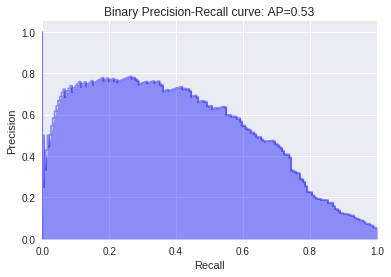

In [ ]:
y_pred = model.predict(X_test)
average_precision = average_precision_score(y_test, y_pred)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.step(recall, precision, color='b', alpha=0.4,where='post')
plt.fill_between(recall, precision, alpha=0.4, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Binary Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

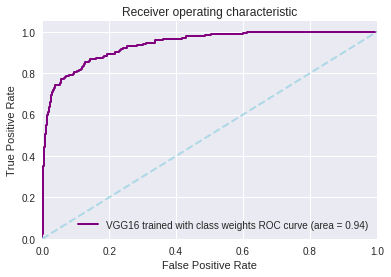

In [ ]:
fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='purple',lw=lw, label='VGG16 trained with class weights ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightblue', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Predict on Whole Slide Image and Heatmap Visualization

In [ ]:
# Function to predict on whole slides and generate cancerous probabilities by patch
def predict_mask(slide, model, h=h, w=w, s=s, level=level, ds= ds):
  i = 0
  patch_probs = []
  slide_h = slide.level_dimensions[level][1]
  slide_w = slide.level_dimensions[level][0]
  count_patches = 0
  count_0 = 0
  while i <= slide_h -h:
      j = 0
      while j <= slide_w -w:
     
          img_region = read_slide(slide, x=j*ds, y=i*ds, level=level, width=w, height=h)
          tissue_pixels = find_tissue_pixels(img_region)
          
          if len(tissue_pixels)/float(h*w) >= 0.01:
            img_region = np.array(img_region).astype('float32')/255
            prob = model.predict(img_region.reshape(1,h,w,3))
            
          else:
            prob = 0
            count_0 += 1
          
          patch_probs.append(prob)
          count_patches += 1
          
          j = j + s

      i = i + s
  print (count_patches,count_0)     
  return np.array(patch_probs)
  

In [ ]:
# Generate heatmap from per-patch cancer probabilities
def get_heatmap(slide, level,preds, h, w, s,thresh = 0.5):

    i = 0
    count = 0
    preds = np.where(preds>=thresh, preds, 0)
    heatmap = np.zeros((slide.level_dimensions[level][1],slide.level_dimensions[level][0]))
    center_x = int((h-s)*0.5)
    center_y = int((w-s)*0.5) 
    
    while i <= heatmap.shape[0]-h:
        j = 0
        while j <= heatmap.shape[1]-w:
            
            block = heatmap[i:i+h,j:j+w]
            block[center_x:center_x+s, center_y:center_y+s] = preds[count]*255
            
            heatmap[i:i+h,j:j+w] = block
            count +=1
            j = j + s

        i = i + s
        
    return heatmap

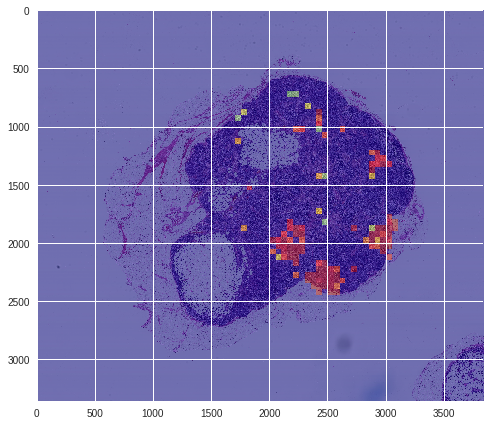

In [ ]:
# Try visualize back on image used in training
## tumor_091
slide=open_slide(slide_paths[0])
# probs = predict_mask(slide = slide, model = model, h=h, w=w, s=s, level=level, ds= ds)
# slide_image = read_slide(slide, 
#                          x=0, 
#                          y=0, 
#                          level=level, 
#                          width=slide.level_dimensions[level][0], 
#                          height=slide.level_dimensions[level][1])

hm = get_heatmap(slide=slide,level =level,preds=probs, h=h, w=w, s=s) 

plt.figure(figsize=(8,8))
plt.imshow(slide_image)
plt.imshow(hm , cmap='jet', alpha=0.5) # Red regions contains cancer.

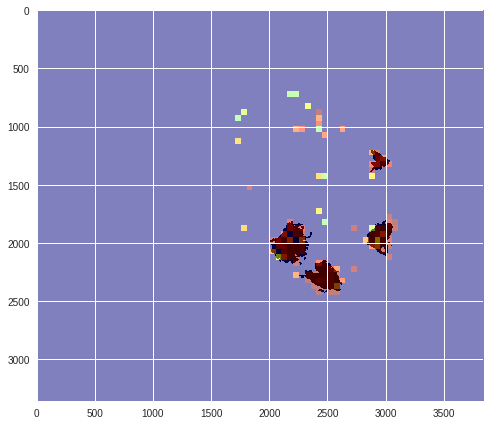

In [ ]:
# Ground truth
level = 4
mask_image = read_slide(open_slide(tumor_mask_paths[0]), 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])[:,:,0]
plt.figure(figsize=(8,8))
plt.imshow(mask_image)
plt.imshow(hm , cmap='jet', alpha=0.5) # Red regions contains cancer.

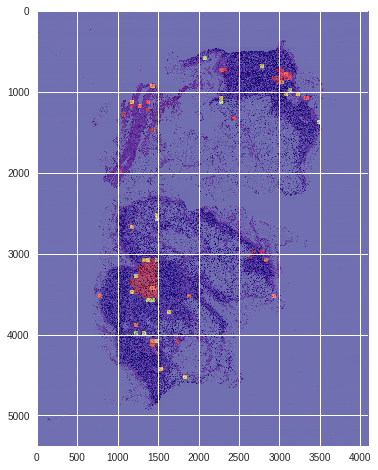

In [ ]:
## tumor_084
slide=open_slide(slide_paths[4])
# probs1 = predict_mask(slide = slide, model = model, h=h, w=w, s=s, level=level, ds= ds)
# slide_image1 = read_slide(slide, 
#                          x=0, 
#                          y=0, 
#                          level=level, 
#                          width=slide.level_dimensions[level][0], 
#                          height=slide.level_dimensions[level][1])
hm1 = get_heatmap(slide=slide,level =level,preds=probs1, h=h, w=w, s=s) 

plt.figure(figsize=(8,8))
plt.imshow(slide_image1)
plt.imshow(hm1 , cmap='jet', alpha=0.5) # Red regions contains cancer.

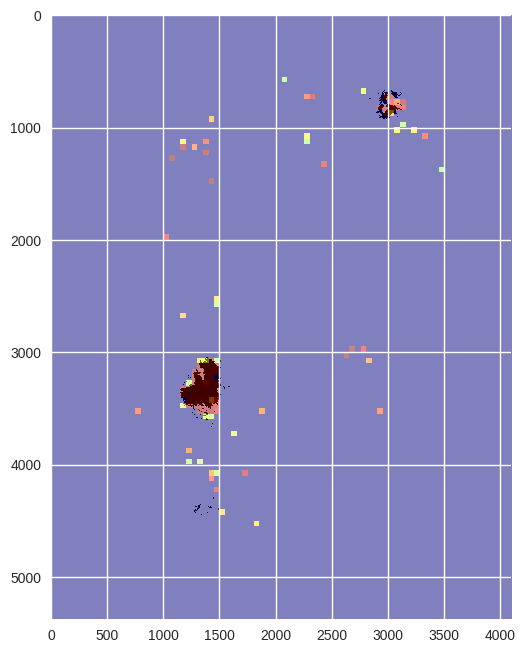

In [ ]:
# Ground truth
level = 4
mask_image = read_slide(open_slide(tumor_mask_paths[4]), 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])[:,:,0]
plt.figure(figsize=(8,8), dpi = 100)
plt.imshow(mask_image)
plt.imshow(hm1 , cmap='jet', alpha=0.5) # Red regions contains cancer.

# Test Image

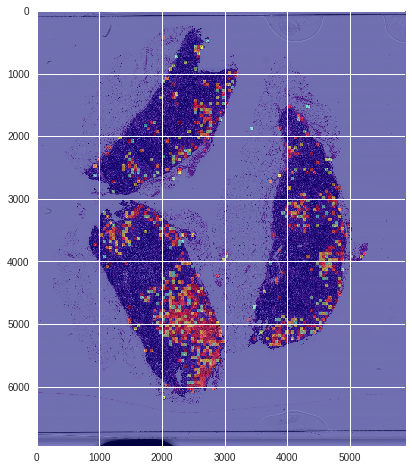

In [ ]:
## Not in the training set, tumor_078
slide=open_slide(slide_paths[6])
probs2 = predict_mask(slide = slide, model = model, h=h, w=w, s=s, level=level, ds= ds)
slide_image2 = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
hm2 = get_heatmap(slide=slide,level =level,preds=probs2, h=h, w=w, s=s, thresh = 0.4) 

plt.figure(figsize=(8,8))
plt.imshow(slide_image2)
plt.imshow(hm2 , cmap='jet', alpha=0.5) # Red regions contains cancer.

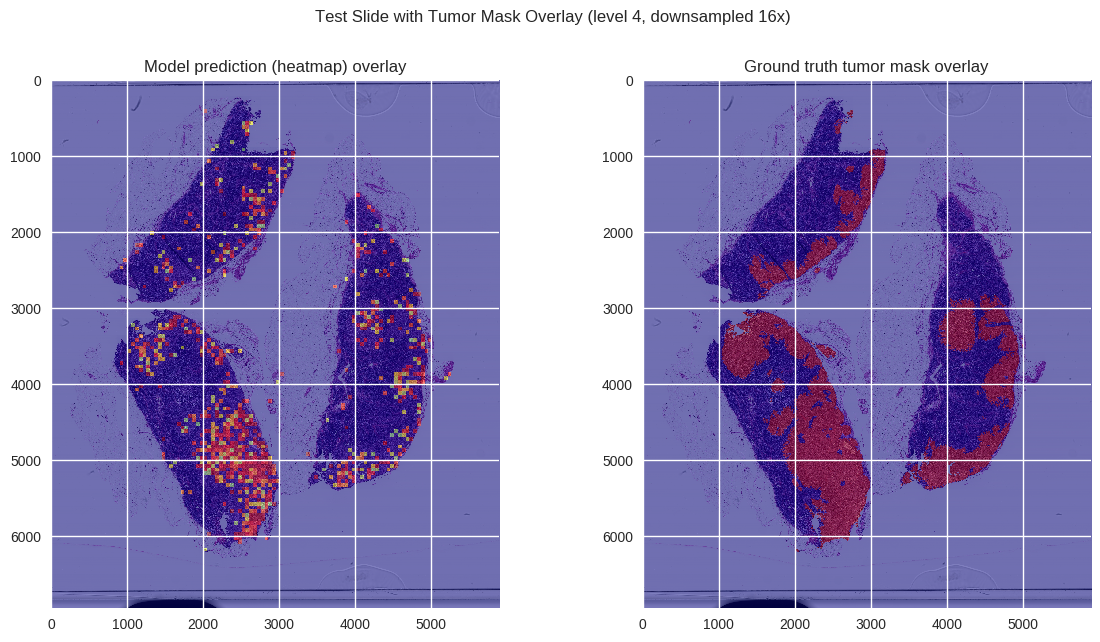

In [ ]:
# Plot side-by-side overlays
level = 4
tumor_mask = open_slide(tumor_mask_paths[6])
mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])[:,:,0]

f, axes = plt.subplots(1, 2, figsize=(14, 7), dpi=100)
ax = axes.ravel()
ax[1].imshow(slide_image2)
ax[1].imshow(mask_image, cmap = 'jet', alpha = 0.5)
ax[1].set_title('Ground truth tumor mask overlay')
ax[0].imshow(mask_image, cmap = 'jet', alpha = 0.5)
ax[0].imshow(hm2, cmap = 'jet', alpha = 0.5)
ax[0].set_title('Model prediction (heatmap) overlay Ground Truth')
f.suptitle('Test Slide with Tumor Mask Overlay (level 4, downsampled 16x)')
plt.show()